<h2> Dieses Notebook führt die Volumenschätzung ausschließlich aus Basis der Tiefenwerte, intrinsischen Matrix und referenz Dimensionen aus, welche direkt aus dem IPhone via Apple SDK gewonnen wurden.

# Import der Libraries

In [19]:
from PIL import Image
import vtk
import pyvista as pv
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
from Functions.processing_depthmap_pc import transform_binary_to_depthmap
import matplotlib.cm as cm 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Tiefenkarte lesen und plotten

Einlesen der Binary

In [20]:
binary_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\Banane1_16Lidar\DepthMap.bin"
depth_map = transform_binary_to_depthmap(binary_url)    

In [21]:
print(depth_map.dtype)


float16


Einlesen des RGB image

In [22]:
rgb_url = r"C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\Code\XCodeDirectExtraction\LidarData\color_image.jpg"
rgb_im = Image.open(rgb_url)

In [23]:
rgb_height, rgb_width =rgb_im.size
rgb_height

1920

Plotten der Tiefenkarte

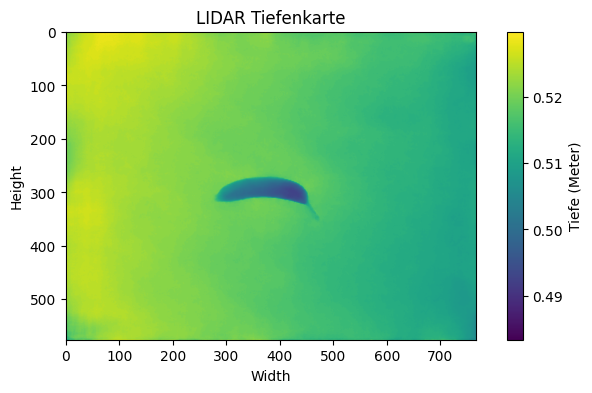

In [24]:
plt.figure(figsize=(8, 4))
plt.imshow(depth_map, cmap = "viridis")
plt.colorbar(label="Tiefe (Meter)")
plt.title("LIDAR Tiefenkarte")
plt.ylabel("Height")
plt.xlabel("Width")
plt.show()


We need to resize the rgb image later to this size to combine depth map and RGB image and create a RGBD image. First we get the size of the depth map and then resize the RGB image to that size.

In [25]:
def resize(rgb_im, depth_im):
    rgb_width, rgb_height = rgb_im.size
    rgb_width_original, rgb_height_original = rgb_im.size #need that for later use
    dm_width, dm_height = depth_im.size  # width and height of depth map image. 
    
    print(f"dm_height:{dm_height}, dm_width:{dm_width}\n rgb_height:{rgb_height}, rgb_width:{rgb_width}")  # need to scale our RGB image to the size of our depthmap image
    
    size = (dm_width, dm_height)  # define new size
    rgb_im = rgb_im.resize(size)  # fitting the rgb image size to the size of the depth image
    
    rgb_width, rgb_height = rgb_im.size
    print(f"new_rgb_height:{rgb_height}, new_rgb_width:{rgb_width}")
    
    return rgb_im, dm_width, dm_height, rgb_width_original, rgb_height_original

# Exiftool camera calibration

In [26]:
dm_height, dm_width= depth_map.shape
dm_height

576

intrinsische Matrix

In [27]:
intrinsic_matrix = np.array([
    [2943.626708984375, 0, 2006.96923828125],
    [0, 2943.626708984375, 1519.7119140625],
    [0, 0, 1]
])

print(intrinsic_matrix)


[[2.94362671e+03 0.00000000e+00 2.00696924e+03]
 [0.00000000e+00 2.94362671e+03 1.51971191e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Referenzdimensionen für die Skalierung der intrinsischen Matrix

In [28]:
#OriginalWerte
# ref_height = 4032
# ref_width = 3024

In [29]:
#Diese Werte nutze ich zum testen, da die Tiefekarte gekippt ist, sind auch höhe und breite vertauscht
ref_height = 3024
ref_width = 4032

In [30]:
# sclaingfactor
scale_x = dm_width / ref_width
scale_y = dm_height / ref_height

# scaling
scaled_mtx = intrinsic_matrix.copy()
scaled_mtx[0, 0] *= scale_x  # f_x
scaled_mtx[1, 1] *= scale_y  # f_y
scaled_mtx[0, 2] *= scale_x  # c_x
scaled_mtx[1, 2] *= scale_y  # c_y

print("Angepasste intrinsische Matrix:")
print(scaled_mtx)

Angepasste intrinsische Matrix:
[[560.69080171   0.         382.27985491]
 [  0.         560.69080171 289.46893601]
 [  0.           0.           1.        ]]


because the depthmap is already processes by the IPhone and normalized, I have to scale to numbers back to meters. the maximum depth captured by the LIDAR sensor seems to be 5 meters.
so the maximum value of the unedited array, which is 255, is equal to 5 meters while 0 = 0 meters.

scaled intrinsic

In [31]:
fx = scaled_mtx[0, 0]
fy = scaled_mtx[1, 1]
cx = scaled_mtx[0, 2]
cy = scaled_mtx[1, 2]

print(f"fx: {fx}, fy: {fy}, cx: {cx}, cy: {cy}")


# Intrinsic Matrix als Open3D-Objekt
intrinsic_scaled = o3d.camera.PinholeCameraIntrinsic(width=dm_width, height=dm_height, fx=fx, fy=fy, cx=cx, cy=cy)


fx: 560.6908017113095, fy: 560.6908017113095, cx: 382.2798549107143, cy: 289.46893601190476


# Create point cloud

Open3D Object without metric scaling

In [32]:
depth_data_uint16_Iphone = (depth_map.astype(np.uint16)) #Quelle: https://stackoverflow.com/questions/73067231/how-to-convert-uint8-image-to-uint16-python
depth_uint16_o3d_Iphone = o3d.geometry.Image(depth_data_uint16_Iphone)

# Open3D-Image aus Tiefenkarte erstellen
depth_image = o3d.geometry.Image(depth_uint16_o3d_Iphone)

In [33]:
depth_image = o3d.geometry.Image(depth_map.astype(np.float32))

Pointcloud

In [34]:
pcd = o3d.geometry.PointCloud.create_from_depth_image(
    depth_image,
    intrinsic_scaled,
    depth_scale=1.0,  # 
    depth_trunc=3.0,  # Maximal erlaubte Tiefe. 3 Meter reichen für unsere Ansprüche.
    stride=1  # Jeder Pixel wird genutztbei Stride = 1
)


In [35]:
num_points = len(np.asarray(pcd.points))
print(f"Anzahl der Punkte in der Punktwolke: {num_points}")

Anzahl der Punkte in der Punktwolke: 442368


In [36]:
o3d.visualization.draw_geometries([pcd])

# Clean Point Cloud

## Estimating normals

In [37]:
nn_distance = np.mean(pcd.compute_nearest_neighbor_distance())

print(nn_distance)

0.0009147431093448308


In [38]:
radius_normals = nn_distance * 4

pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

pcd.paint_uniform_color([0.6, 0.6, 0.6])
#o3d.visualization.draw_geometries([pcd])

PointCloud with 442368 points.

To get better results from the PC for the volume estimation I will clean it using Open3D methods

In [39]:
pcd_center = pcd.get_center()
pcd.translate(pcd_center)

PointCloud with 442368 points.

## Plane segmentation with RANSAC

In [40]:
plane_model, inliers = pcd.segment_plane(
    distance_threshold=0.007, # für bilder mit teller sind 0,005 besser geeignet!
    ransac_n=10,
    num_iterations=6000,
    probability=0.9999
)

[a, b, c, d] = plane_model.tolist()

# Inlier- und Outlier-Punktwolken
pcd_plane = pcd.select_by_index(inliers)
inlier_cloud = pcd_plane.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)

# Darstellung der Punktwolken
#o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [41]:
o3d.visualization.draw_geometries([outlier_cloud])

In [42]:
o3d.visualization.draw_geometries([outlier_cloud,pcd_plane])

In [43]:
pcd_object = outlier_cloud

## Statistical oulier removal (SOR)
Bereinigung der Punktwolke mit Statistical Outlier Removal

In [44]:
#Quelle: https://www.open3d.org/docs/latest/tutorial/Advanced/pointcloud_outlier_removal.html

def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

Removing the outliers

In [45]:
cl, ind = pcd_object.remove_statistical_outlier(nb_neighbors=800, std_ratio=1.1) #gute Ergebnisse mit diesen Werten bisher

Displaying inlier in grey and outlier in red

In [46]:
display_inlier_outlier(pcd_object, ind)

Showing outliers (red) and inliers (gray): 


We will use this PC from now on

In [47]:
# Cleaned PC
pcd_object = pcd_object.select_by_index(ind)  # Nur Inlier

Clean Plane too 

In [48]:
cl, ind = pcd_plane.remove_statistical_outlier(nb_neighbors=500, std_ratio=1.2) #gute Ergebnisse mit diesen Werten bisher

In [49]:
# Cleaned PC
pcd_plane = pcd_plane.select_by_index(ind)  # Nur Inlier

In [50]:
plane_array = np.asarray(pcd_plane.points, dtype=np.float16)

In [51]:
o3d.visualization.draw_geometries([pcd_plane], window_name="RANSAC Plane") 

In [52]:
o3d.visualization.draw_geometries([pcd_object], window_name="RANSAC Plane") 

Visualizing the new PC of the object

In [33]:
pcd_object_array = np.asarray(pcd_object.points, dtype=np.float16)

In [34]:
print(pcd_object_array.dtype)

float16


## Punktwolke berichtigen

Das Problem beim Extrahieren des jeweiligen Lebensmittels ist, dass, da nicht alle Punkte in der Tiefenkarte sichtbar sind, diese Punkte fehlen und das Objekt an Höhe verliert, sobald man den RANSAC-Algorithmus ausführt.
Um die korrekte Höhe beizubehalten, kann man das Lebensmittel bis zur ebenen Fläche erweitern und somit vervollständigen.  

Wir benötigen die untersten Punkte der Objekt-Punktwolke

In [35]:
# Maximalen z-Wert des Objekts bestimmen
max_z_object = max(pcd_object_array[:, 2].tolist())  # Nutzt weniger RAM als np.max()
print(f"Tiefster z-Wert des Objekts: {max_z_object}")

Tiefster z-Wert des Objekts: 1.0302734375


In [36]:
# Durchschnitt
avg_z_plane = plane_array[:, 2].mean()
print(f"Durchschnittliche Tiefe der Ebene: {avg_z_plane}")

Durchschnittliche Tiefe der Ebene: 1.0361328125


In [37]:
# Minimalen z-Wert der Ebene bestimmen
max_z_plane = plane_array[:, 2].max()
print(f"Tiefster z-Wert der Ebene: {max_z_plane}")

Tiefster z-Wert der Ebene: 1.0458984375


This code extends all the points of the object and thus creates a dense object. 

### Ganze PCD ausfüllen

In [43]:
o3d.visualization.draw_geometries([pcd_object,pcd_plane])


In [44]:
# 4. Punkte in Z-Richtung erweitern

new_points_dos = []
for x, y, z in pcd_object_array:
    # Falls der Punkt zu tief liegt, berechne eine Korrektur
    
    current_z = z
    while current_z < avg_z_plane:
        current_z += 0.0015
        if current_z > avg_z_plane:
            break
        new_points_dos.append([x, y, current_z])


# 5. Neue Punkte zur Open3D Punktwolke hinzufügen
new_points_dos = np.array(new_points_dos)  # Am Ende in ein numpy-Array umwandeln

# 7. Punktwolke der neuen Punkte visualisieren

new_points_pcd_dos = o3d.geometry.PointCloud()
new_points_pcd_dos.points = o3d.utility.Vector3dVector(new_points_dos)

o3d.visualization.draw_geometries([new_points_pcd_dos])

In [45]:
# Funktion zum Spiegeln der Punktwolke entlang der Z-Achse
def invert_pcd_z(pcd):
    points = np.asarray(pcd.points)
    points[:, 2] *= -1  # Z-Koordinaten invertieren
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd

# Punktwolken laden
new_points_pcd_dos = invert_pcd_z(new_points_pcd_dos)
pcd_plane = invert_pcd_z(pcd_plane)

Weiterer SOR

In [46]:
# cl, ind = new_points_pcd_dos.remove_statistical_outlier(nb_neighbors=800,
#                                                 std_ratio=0.8)  #gute Ergebnisse mit diesen Werten bisher
# 
# display_inlier_outlier(new_points_pcd_dos, ind)
# 
# new_points_pcd_dos = pcd_object.select_by_index(ind)  # Nur Inlier

In [48]:
o3d.visualization.draw_geometries([new_points_pcd_dos, pcd_plane])

Punkte generieren Quelle: https://stackoverflow.com/questions/65774814/adding-new-points-to-point-cloud-in-real-time-open3d

# Zusammenfassung der Punktwolke

## Ausdehnung des Objekts

In [88]:
bounds = new_points_pcd_dos.get_max_bound() - new_points_pcd_dos.get_min_bound()
print(f"Ausdehnung der Punktwolke: x={bounds[0]:.3f}, y={bounds[1]:.3f}, z={bounds[2]:.3f}")

Ausdehnung der Punktwolke: x=0.152, y=0.045, z=0.024


# Volumenberechnung

We use this for a uniform visualization

In [75]:
front = [ -0.068172171837332235, 0.49667857217321404, 0.86525311379443104 ]
lookat = [ -0.015313023275404611, 0.0047471773344458217, -1.0292862545403776 ]
up = [ -0.011764193049956025, -0.86761065292023309, 0.4971049775462022 ]
zoom = 0.33999999999999986

## Voxelization

Sehr wichtig!: Wenn wir statt einfach nur die border zu erweitern und mit der ursprünglichen PCD des Objekts verbinden, die ursprüngliche PCD (ist ja eine Hülle) erweitern und so ein ausgefülltes Objekt erhalten und dieses dann nutzen, um mit Voxelization das Volumen zu erhalten, dann ist das Ergebnis viel besser. Das 

In [154]:
# Voxelgröße (anpassen je nach Detailgrad)
voxel_size = 0.0015  # 1,3mm pro Voxel ist gut. ggf. kann ich ein algorithmus schrieben der die "perfekte" size findet in dem dieser selbst den wert nach oben oder unten justiert

# Voxelgrid aus der Punktwolke erstellen
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(new_points_pcd_dos, voxel_size=voxel_size)

# Berechne das Volumen
voxel_volumen = len(voxel_grid.get_voxels()) * (voxel_size ** 3)

print(f"Geschätztes Volumen der Punktwolke: {voxel_volumen:.6f} m³")

Geschätztes Volumen der Punktwolke: 0.000081 m³


In [163]:
o3d.visualization.draw_geometries([voxel_grid], front=front, lookat=lookat, up=up, zoom=zoom)

In [45]:
# Berechne das Volumen
voxel_volumen = len(voxel_grid.get_voxels()) * (voxel_size ** 3)

print(f"Geschätztes Volumen der Punktwolke: {voxel_volumen:.6f} m³")

# **Visualisierung der Voxel**
#o3d.visualization.draw_geometries([voxel_grid])

Geschätztes Volumen der Punktwolke: 0.000185 m³


## Convex Hull

In [113]:
# calculate hull
hull_mesh, hull_vertices = new_points_pcd_dos.compute_convex_hull()

hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull_mesh)

hull_ls.paint_uniform_color([1, 0, 0])

o3d.visualization.draw_geometries([new_points_pcd_dos, hull_ls], front=front, lookat=lookat, up=up, zoom=zoom)

volume = hull_mesh.get_volume()


In [58]:
volume_ml = volume * 1_000_000  # Umrechnung von m³ in ml
print(f"Volumen: {volume_ml:.2f} ml")

Volumen: 92.64 ml


## Bounding Box

In [92]:
# nn_distance = np.mean(new_points_pcd_dos.compute_nearest_neighbor_distance())
# 
# print(nn_distance)
# radius_normals = nn_distance * 4
# 
# new_points_pcd_dos.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16),
#                      fast_normal_computation=True)
# 
# new_points_pcd_dos.paint_uniform_color([0.6, 0.6, 0.6])
# #o3d.visualization.draw_geometries([pcd])

0.0008608642592084696


PointCloud with 159055 points.

In [114]:
# Axis-Aligned Bounding Box (AABB) berechnen und visualisieren
# aabb = new_points_pcd_dos.get_axis_aligned_bounding_box()
# aabb.color = (1, 0, 0)  # Rot

# Oriented Bounding Box (OBB) berechnen
oriented_bb = new_points_pcd_dos.get_minimal_oriented_bounding_box()
oriented_bb.color = (0, 1, 0)  # Grün


# Volumenberechnung der OBB
obb_extents = oriented_bb.extent
obb_volume = obb_extents[0] * obb_extents[1] * obb_extents[2]

print(f"Volumen der Oriented Bounding Box (OBB): {obb_volume:.2f}")

#Debugging: Bounding-Box-Größe prüfen
# min_bound = new_points_pcd_dos.get_min_bound()
# max_bound = new_points_pcd_dos.get_max_bound()
# print(f"Min Bound: {min_bound}, Max Bound: {max_bound}")
# print(f"AABB Größe: {aabb.get_extent()}")
# print(f"OBB Größe: {obb_extents}")

obb_volume = np.prod(obb_extents)
print(f"Korrigiertes OBB-Volumen: {obb_volume:.6f} m³")


Volumen der Oriented Bounding Box (OBB): 0.00
Korrigiertes OBB-Volumen: 0.000156 m³


In [182]:
# Bounding-Boxen und Punktwolke visualisieren
o3d.visualization.draw_geometries([new_points_pcd_dos, oriented_bb], front=front, lookat=lookat, up=up, zoom=zoom)

## Alpha shapes

In [51]:
nn_distance = np.mean(new_points_pcd_dos.compute_nearest_neighbor_distance())

print(nn_distance)
radius_normals = nn_distance * 4

new_points_pcd_dos.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16),
                     fast_normal_computation=True)

new_points_pcd_dos.paint_uniform_color([0.6, 0.6, 0.6])
#o3d.visualization.draw_geometries([new_points_pcd_dos])

0.0008882159595501898


PointCloud with 64004 points.

In [84]:
# Quelle Code: https://www.open3d.org/docs/latest/tutorial/Advanced/surface_reconstruction.html
# Quelle Theorie:  [Edelsbrunner1983] Edelsbrunner and D. G. Kirkpatrick and R. Seidel: On the shape of a set of points in the plane, IEEE Transactions on Information Theory, 29 (4): 551–559, 1983

alpha = 0.2
print(f"alpha={alpha:.3f}")
alpha_shape  = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(new_points_pcd_dos, alpha)
alpha_shape.compute_vertex_normals()
o3d.visualization.draw_geometries([alpha_shape], mesh_show_back_face=True)
print(f"Anzahl Dreiecke: {len(alpha_shape.triangles)}")

alpha=0.200
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra in TetraMesh
[Open3D WARNING] [CreateFromPointCloudAlphaShape] invalid tetra 

In [85]:
o3d.visualization.draw_geometries([alpha_shape], front=front, lookat=lookat, up=up, zoom=zoom, mesh_show_back_face=True)

In [86]:
geoms = [alpha_shape]
vis_screenshot(geoms)

Screenshot gespeichert unter: C:\Users\Diren\Nextcloud\HTW\4.Semester-Masterarbeit\Masterarbeit\GenutzteBilder\screenshot.png


In [79]:
# Volumenberechnung mit Tetrahedron Decomposition (Delaunay Triangulation)
def compute_mesh_volume(mesh):
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    
    volume = 0.0
    for tri in triangles:
        v0, v1, v2 = vertices[tri[0]], vertices[tri[1]], vertices[tri[2]]
        tetra_volume = np.dot(v0, np.cross(v1, v2)) / 6.0  # Volumen eines Tetraeders
        volume += tetra_volume
    
    return abs(volume)

# Volumen berechnen
volumen = compute_mesh_volume(alpha_shape)
print(f"Volumen des Alpha Shapes: {volumen:.5f} m³")


Volumen des Alpha Shapes: 0.00009 m³


# Visualisierungen

Achtung: Bei der Matplot Varainte, sind die Achsen noch mit den Tiefenwerten versehen. Das muss ich mit den eigentlichen Längen ändern!

## Voxel

In [ ]:
#Quelle: https://matplotlib.org/stable/gallery/mplot3d/voxels_rgb.html
# Voxelgröße definieren
voxel_size = 0.0015

# Voxelgrid aus der Punktwolke erstellen
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(new_points_pcd_dos, voxel_size=voxel_size)

# Voxel extrahieren
voxels = voxel_grid.get_voxels()

# Gittergröße bestimmen (maximale Indizes der Voxel)
max_x = max(v.grid_index[0] for v in voxels) + 1
max_y = max(v.grid_index[1] for v in voxels) + 1
max_z = max(v.grid_index[2] for v in voxels) + 1
min_z = min(v.grid_index[2] for v in voxels)  # Kleinste Höhe für Normalisierung

# 3D-Array für Voxel erstellen (alle False = leer)
voxel_matrix = np.zeros((max_x, max_y, max_z), dtype=bool)
colors = np.empty((max_x, max_y, max_z, 4), dtype=np.float32)  # RGBA-Farben

# Colormap wählen (z.B. "jet" oder "viridis")
colormap = cm.get_cmap("jet")

# Existierende Voxel setzen & Farbe nach Höhe bestimmen
for v in voxels:
    x, y, z = v.grid_index

    # Voxel als vorhanden markieren
    voxel_matrix[x, y, z] = True

    # Höhe normalisieren (zwischen 0 und 1)
    normalized_height = (z - min_z) / (max_z - min_z)

    # Farbe aus der Colormap holen
    color = colormap(normalized_height)  # Gibt (R, G, B, A)-Werte zurück
    colors[x, y, z] = color  # RGBA-Farbzuweisung

# Matplotlib-Plot erstellen
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Voxel mit Farben nach Höhe darstellen
ax.voxels(voxel_matrix, facecolors=colors, edgecolors='k')

# Achsentitel setzen
ax.set_xlabel("X-Achse")
ax.set_ylabel("Y-Achse")
ax.set_zlabel("Z-Achse")
ax.set_title("Voxel-Darstellung")

plt.show()

## Convex Hull

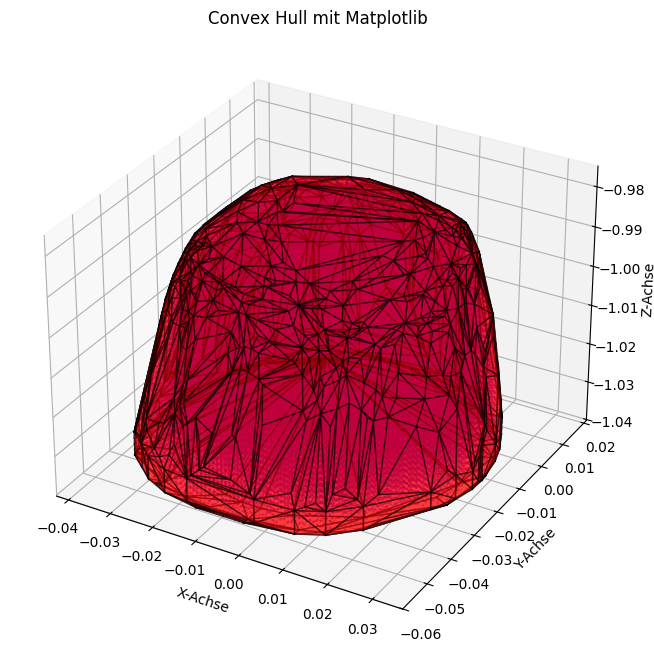

In [52]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Berechne die konvexe Hülle der Punktwolke
hull_mesh, hull_vertices = new_points_pcd_dos.compute_convex_hull()

# Extrahiere die Eckpunkte (Vertices) und Dreiecke (Triangles) der Hülle
vertices = np.asarray(hull_mesh.vertices)  # Alle Punkte der Hülle
triangles = np.asarray(hull_mesh.triangles)  # Indizes der Dreiecke

# Matplotlib-Figur erstellen
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

# Punkte der Punktwolke für Referenz zeichnen
points = np.asarray(new_points_pcd_dos.points)
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='blue', alpha=0.3, s=1)  # Punktwolke

# Dreiecksmesh für die Hülle erstellen und visualisieren
hull_collection = Poly3DCollection(vertices[triangles], alpha=0.5, edgecolor='k', facecolor='red')
ax.add_collection3d(hull_collection)

# Achsentitel setzen
ax.set_xlabel("X-Achse")
ax.set_ylabel("Y-Achse")
ax.set_zlabel("Z-Achse")
ax.set_title("Convex Hull mit Matplotlib")

plt.show()


#  Test

## interpolate pcd for better results using voxelization

In [45]:
cl, ind = new_points_pcd_dos.remove_statistical_outlier(nb_neighbors=400, std_ratio=1.0) #gute Ergebnisse mit diesen Werten bisher

In [46]:
new_points_pcd_dos

PointCloud with 158006 points.

In [47]:
cl

PointCloud with 136558 points.

In [48]:
o3d.visualization.draw_geometries([cl])


In [49]:
nn_distance = np.mean(cl.compute_nearest_neighbor_distance())

print(nn_distance)

0.0008461078819643869


In [50]:
radius_normals = nn_distance * 4

cl.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normals, max_nn=16), fast_normal_computation=True)

cl.paint_uniform_color([0.6, 0.6, 0.6])
#o3d.visualization.draw_geometries([pcd])

PointCloud with 136558 points.

In [51]:
# Poisson-Rekonstruktion
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(cl, depth=9)

# Punktwolke aus Mesh extrahieren
pcd_dense = mesh.sample_points_uniformly(number_of_points=1000000)  # Anzahl erhöhen für mehr Dichte

In [ ]:
o3d.visualization.draw_geometries([pcd_dense])

In [52]:
cl, ind = pcd_dense.remove_statistical_outlier(nb_neighbors=400,
                                                        std_ratio=1.0)  #gute Ergebnisse mit diesen Werten bisher

In [53]:
o3d.visualization.draw_geometries([cl])

In [54]:
# Voxelgröße (anpassen je nach Detailgrad)
voxel_size = 0.007  # 1,3mm pro Voxel ist gut. ggf. kann ich ein algorithmus schrieben der die "perfekte" size findet in dem dieser selbst den wert nach oben oder unten justiert

# Voxelgrid aus der Punktwolke erstellen
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(cl, voxel_size=voxel_size)

# Berechne das Volumen
voxel_volumen = len(voxel_grid.get_voxels()) * (voxel_size ** 3)

print(f"Geschätztes Volumen der Punktwolke: {voxel_volumen:.6f} m³")

# **Visualisierung der Voxel**
o3d.visualization.draw_geometries([voxel_grid])

Geschätztes Volumen der Punktwolke: 0.000201 m³


In [55]:
 pcd_dense

PointCloud with 1000000 points.

## DBSCAN-Clustering

In [139]:
# DBSCAN-Clustering
eps = 0.02  # Radius für Nachbarn
min_points = 50  # Mindestanzahl von Punkten in einem Cluster
labels = np.array(pcd.cluster_dbscan(eps=eps, min_points=min_points, print_progress=True))

num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Anzahl der Cluster: {num_clusters}")

# colors for clusters
colors = plt.get_cmap("tab20")(labels / (num_clusters if num_clusters > 0 else 1))
colors[labels < 0] = 0  # Rauschen (Label -1) schwarz färben
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

o3d.visualization.draw_geometries([pcd])

Anzahl der Cluster: 1


In [ ]:
for cluster_id in np.unique(labels):
    cluster_size = np.sum(labels == cluster_id)
    if cluster_id == -1:
        print(f"Rauschen: {cluster_size} Punkte")
    else:
        print(f"Cluster {cluster_id}: {cluster_size} Punkte")

In [ ]:
# ID des zu entfernenden Clusters
cluster_to_remove = 1  

# Indizes der Punkte im Cluster finden
indices_to_remove = np.where(labels == cluster_to_remove)[0]

# Punktwolke ohne unerwünschte Cluster erstellen
remaining_cloud = pcd.select_by_index(indices_to_remove, invert=True)

# Visualisierung
o3d.visualization.draw_geometries([remaining_cloud], window_name="Bereinigte Punktwolke")
